In [1]:
# !pip install PyDrive

In [2]:
import warnings
warnings.filterwarnings("ignore")
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

In [3]:
import cv2
def check_cam():
    cap1 = cv2.VideoCapture(0)
    cap2 = cv2.VideoCapture(1)
    cv2.namedWindow('Webcam 1')
    cv2.namedWindow('Webcam 2')

    while True:
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        cv2.imshow('Webcam 1', frame1)
        cv2.imshow('Webcam 2', frame2)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcams and destroy all windows
    cap1.release()
    cap2.release()
    cv2.destroyAllWindows()
# check_cam()

In [4]:
import numpy as np
import cv2
import random
import pygame
import pickle

def init_cameras(id1=0, id2=1):
    '''Инициализация и возврат 2х камер'''
    cap1 = cv2.VideoCapture(id1)
    cap2 = cv2.VideoCapture(id2)
    cv2.namedWindow('Webcam 1')
    cv2.namedWindow('Webcam 2')
    return cap1, cap2
    
def get_frame():
    '''Функция захвата фреймов с 2х камер, предполагает, что устройства уже открыты глобально'''
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()
    cv2.imshow('Webcam 1', frame1)
    cv2.imshow('Webcam 2', frame2)
    return (frame1, frame2)

def setup_pygame(width, heigth):
    '''Инииализация и возврат экрана'''
    pygame.init()
    screen = pygame.display.set_mode((0, 0), pygame.FULLSCREEN)
    screen.fill((255, 255, 255))  # white
    return screen

def create_points(n_points, window_width, window_heigth):
    '''Функция создания точек по периметру экрана, между которыми будет бегать курсор 
    в количестве n_points на каждой из сторон экрана, порядок точек образует как бы 2 змейки'''
    points = [] 
    x1 = np.linspace(0, window_width, n_points, dtype = 'int') #как линейное пространство от 0 до 
    y1 = np.array([0, window_heigth]*(n_points//2)) #максимальной ширины в количестве n_points
    x2 = np.array([0, window_width]*(n_points//2))
    y2 = np.linspace(window_heigth, 0, n_points, dtype = 'int')
    points = list(zip(np.append(x1,x2), np.append(y1,y2)))

    return points

def move_to_points(screen, list_of_points, n, speed = 9999, capture = True):
    '''Функция генерации данных, принимает на вход pygame.screen, список крайних точек между которыми
    она добавит промежуточные точки в количестве n, speed - скорость перехода между точками, флаг 
    capture указывает на то нужно ли сохранять захваты с камер. Функция предполагает что если capture = True
    то глобально уже существуют два устройства opencv: cap1 и cap2, которые через фунцию get_frame вернут
    2 изображения, которые будут сохранены как соответствующие записи в результирующем списке. Таким же
    образом будут сохранены координаты курсора. '''    
    data = [] # Результат работы функции накапливается здесь
    clock = pygame.time.Clock() #Часы для задания скорости
    for ((sx, sy),(ex,ey)) in zip(list_of_points[:-1], #Берем координаты текущей и 
                                  list_of_points[1:]): #следующей точки
        for x, y in zip(np.linspace(sx, ex, n, dtype='int'), #Бежим по промежуточным координатам
                        np.linspace(sy, ey, n, dtype='int')):#
            
            for event in pygame.event.get(): #Для прерывания цикла кнопкой q
                if event.type == pygame.QUIT or (event.type == pygame.KEYDOWN and event.key == pygame.K_q):
                    pygame.quit()

            screen.fill((255, 255, 255)) #Заливаем экран       
            pygame.draw.circle(screen, (0, 0, 0), [x,y], 5)   #Рисуем курсор в виде черного кружка в текущих координатах        
            clock.tick(speed) #Скорость            
            pygame.display.update() #Обновляем экран          
    
            if capture: #Делаем захват с камер, если нужно
                frame1, frame2 = get_frame()
            else:
                frame1, frame2 = [],[]
            data.append({'coords': (x,y), 'camera1':frame1, 'camera2':frame2}) #Делаем текущую запись
    pygame.quit()  #Закрываем экран   
    return data

pygame 2.3.0 (SDL 2.24.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
n_points = 16
WINDOW_WIDTH = 1920
WINDOW_HEIGTH = 1080

In [6]:
def make_data():
    points = create_points(n_points, WINDOW_WIDTH, WINDOW_HEIGTH)
    screen = setup_pygame(WINDOW_WIDTH,WINDOW_HEIGTH)

    cap1, cap2 = init_cameras()
    input()
    data = move_to_points(screen, points, n=128, capture=True)
    return data
# data = make_data()

In [7]:
# with open('frames.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open('frames2.pickle', 'rb') as handle:
        data = pickle.load(handle)          
# data = data[::10]

(1073, 256)


<Figure size 640x480 with 0 Axes>

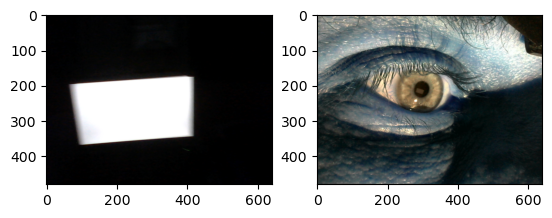

In [9]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import random
item = random.choice(data)
img1, img2, (x, y) = item['camera1'], item['camera2'], item['coords']

plt.figure()
f, axis = plt.subplots(1,2)
print((int(x),int(y)))
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axis[0].imshow(img1)
axis[1].imshow(img2)


In [10]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torchvision.models as models
from torch import nn
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast, GradScaler


VAL_TEST_RATIO = 0.9
TRAIN_VALTEST_RATIO = 0.8
BATCH_SIZE = 12
class EyeDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        camera1 = self.data[idx]['camera1']
        camera2 = self.data[idx]['camera2']
        coords = self.data[idx]['coords']
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return camera1, camera2, coords

def collate_batch(batch):
    camera1, camera2, coords = [],[],[]
    for _data in batch:    
#         print(_data)
        camera1.append(_data[0]/256)
        camera2.append(_data[1]/256)
        coords.append((_data[2][0]/WINDOW_WIDTH, _data[2][1]/WINDOW_HEIGTH))       
    camera1, camera2, coords = np.array(camera1), np.array(camera2), np.array(coords)
    return torch.FloatTensor(camera1), torch.FloatTensor(camera2), torch.FloatTensor(coords)
    

train_records, val_test_records = train_test_split(data, train_size=TRAIN_VALTEST_RATIO, 
                                             random_state=42)
val_records, test_records = train_test_split(val_test_records, train_size=VAL_TEST_RATIO, 
                                             random_state=42)

In [11]:
len(train_records), len(val_records), len(test_records)

(3174, 714, 80)

In [12]:
train_dataset, val_dataset, test_dataset = EyeDataset(train_records), EyeDataset(val_records), EyeDataset(test_records)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [13]:
%%timeit
item = next(iter(train_loader))

149 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
vgg11_1 = models.vgg11(pretrained=True)
vgg11_2 = models.vgg11(pretrained=True)
PRECLS_OUT = 32

In [15]:
for i in [5,5]:
    del (vgg11_1.classifier[i])
    del (vgg11_2.classifier[i])

vgg11_1.classifier[3]= nn.Linear(4096, PRECLS_OUT)
vgg11_2.classifier[3]= nn.Linear(4096, PRECLS_OUT)

In [16]:
class EyeTracker(nn.Module):
    def __init__(self, precls_out):
        super(EyeTracker, self).__init__()
        self.vgg1 = vgg11_1
        self.vgg2 = vgg11_2
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(precls_out*2, precls_out)
        self.fc2 = nn.Linear(precls_out, 2)
        self.activ = nn.ReLU()

    def forward(self, image1, image2):
        out1 = self.vgg1(image1)
        out1 = self.dropout(out1)
        out2 = self.vgg2(image2)
        out2 = self.dropout(out2)

        out = torch.cat((out1, out2),dim=1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.activ(out)
        out = self.fc2(out)       
        return out   

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, y_pred, y_true):
        mse = nn.MSELoss()
        mse_loss = mse(y_pred, y_true)
        rmse_loss = torch.sqrt(mse_loss)
        return rmse_loss

In [17]:
from scipy.ndimage.filters import gaussian_filter1d
'''Функция отрисовки истории обучения со сглаживанием'''

def plot_history(train_history, val_history, batch_size=BATCH_SIZE):    
    fig = plt.figure(figsize=(12, 4))
    '''Блок для трейн лосса'''
    ax1 = fig.add_subplot()    
    ax1.plot(gaussian_filter1d(train_history, sigma=128/batch_size), 
             label='Train loss', color = 'steelblue')    
    ax1.set_yticks(np.linspace(min(train_history+val_history), max(train_history+val_history), 10,  
                               dtype='float16'))   
    ax1.set_ylabel('Loss')                
    ax1.set_xlabel('Batch')  
    ax1.grid(axis = 'y')   

    '''Блок для валидационного лосса'''    
    ax2 = ax1.twiny()       
    ax2.plot(val_history, label='Valid loss', color = 'orange')            
    ax2.set_xlabel('Epochs')
    ax2.set_xticks(np.arange(len(val_history))) 
    ax2.grid()
    
      
    '''Легенда'''
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()    
    
    ax1.legend(handles=handles1+handles2, labels=labels1+labels2, 
               loc='center right')    
    plt.show()

In [18]:
import torchvision
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EyeTracker(PRECLS_OUT).to(device)#.half()

In [19]:
%%time
from torch.optim import Adam, AdamW, lr_scheduler
from IPython.display import clear_output

EPOCHS = 15
lr_cnn = 1e-5
lr_cls = 1e-3

criterion = RMSELoss()
# criterion = nn.MSELoss()
scaler = GradScaler()

optimizer_cnn = Adam([
    {'params': model.vgg1.features.parameters()},
    {'params': model.vgg2.features.parameters()}], lr = lr_cnn)

optimizer_cls = Adam([
    {'params': model.vgg1.classifier.parameters()},
    {'params': model.vgg2.classifier.parameters()},
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}], lr = lr_cls)

scheduler_cnn = lr_scheduler.StepLR(optimizer_cnn, step_size=1, gamma=0.5, verbose=False)
scheduler_cls = lr_scheduler.StepLR(optimizer_cls, step_size=1, gamma=0.5, verbose=False)

def test_model(model, test_loader, criterion):
    model.eval()
    cum_loss = []
    criterion = RMSELoss()
    with torch.no_grad():

        for batch in tqdm(train_loader):
            image1, image2, coords = batch
            image1 = image1.permute(0,3,2,1).to(device)#.half()
            image2 = image2.permute(0,3,2,1).to(device)#.half()
            target = coords.to(device)
            out = model(image1, image2)

            loss = criterion(out, target).cpu().item()                
            cum_loss.append(loss)

        loss = np.mean(cum_loss)        
        return loss

# def train_epoch(model, train_loader, criterion, optimizer_cnn, optimizer_cls, half=False):
    
    
def train(model, criterion, optimizer_cnn, optimizer_cls, scheduler_cnn, scheduler_cls,
          EPOCHS, train_loader, val_loader, half=False):
    train_history = []
    val_history = []
    best_loss = 5
    cnt = 0
    LOG = []
    for epoch in range(1, EPOCHS+1):
        print(f'Epoch:{epoch}/{EPOCHS}')
        model.train()
        pbar = tqdm(train_loader)
        for batch in pbar:
            optimizer_cnn.zero_grad()           
            optimizer_cls.zero_grad()     
            image1, image2, coords = batch
            image1 = image1.permute(0,3,2,1).to(device)#.half()
            image2 = image2.permute(0,3,2,1).to(device)#.half()
            target = coords.to(device)#.half()
            if half:
                with autocast():
                    out = model(image1, image2)
                    loss = criterion(out, target)
            else:
                out = model(image1, image2)
                loss = criterion(out, target)
            loss.backward()

            optimizer_cnn.step()        
            optimizer_cls.step()  

            train_history.append(loss.detach().cpu().numpy())  
            pbar.set_description(f'''Train Loss: {train_history[-1]:.2f}, 
                                 emb_lr: {optimizer_cnn.param_groups[0]['lr']:.2E},
                                 cls_lr: {optimizer_cls.param_groups[0]['lr']:.2E}''')  

        '''Валидация'''
        val_loss = test_model(model, val_loader, criterion)
        
        if epoch == 1:
            val_history.append(np.mean(train_history[:10]))         
        else:
            val_history.append(val_loss)        
        
        train_loss = np.mean(train_history[-len(train_records)//BATCH_SIZE//10:])
        epoch_time = int(pbar.format_dict['elapsed'])         
        LOG.append(f'Epoch:{epoch} Train loss:{train_loss:.3f} '+
                   f'Val loss:{val_loss:.3f} '+
                   f'Epoch time:{epoch_time:d}s\n')
        
        print(f'Val_loss: {val_loss:.3f} Train loss: {loss:.3f}\n') 
        clear_output()
        print(*LOG, sep = '')
        plot_history(train_history[2:], val_history, batch_size=BATCH_SIZE)
        if val_loss < best_loss:        
            print(f'***Save the best model***\n')
            torch.save(model, './best_vgg_loss_model.pth')                 
            best_loss = val_loss
            cnt = 0   
        else: # Иначе увеличиваем счетчик, и если он уже больше определенного значения, понижаем lr
            cnt += 1
            if cnt >=3:  
                print('***Adjusting learning rate, reload best model***')
                model = torch.load('./best_vgg_loss_model.pth').to(device)
                scheduler_cnn.step()
                scheduler_cls.step()
        #Если счетчик достиг критического значения, выходим из обучения'''
        if cnt == 10:
            print('Stop training')            
            break
    return model, train_history, val_history
    
# model, train_history, val_history = train(model,criterion, optimizer_cnn, optimizer_cls, scheduler_cnn, scheduler_cls,
#                                           EPOCHS, train_loader, val_loader, half=False)

CPU times: user 1.68 ms, sys: 86 µs, total: 1.76 ms
Wall time: 1.44 ms


In [20]:
model = torch.load('./best_vgg_loss_model.pth').to(device)
test_model(model, test_loader, criterion)

  0%|          | 0/265 [00:00<?, ?it/s]

0.08585533152492542

In [23]:
all_loader = DataLoader(EyeDataset(data), batch_size=1, shuffle=False, collate_fn=collate_batch)

In [40]:
def eye_track(model):   
    screen = setup_pygame(WINDOW_WIDTH,WINDOW_HEIGTH)
    cap1, cap2 = init_cameras()
    for record in all_loader:  
        for event in pygame.event.get(): #Для прерывания цикла кнопкой q
            if event.type == pygame.QUIT or (event.type == pygame.KEYDOWN and event.key == pygame.K_q):
                pygame.quit()

        screen.fill((255, 255, 255)) #Заливаем экран  
        
        
        frame1, frame2 = record[0], record[1]
        image1 = record[0].permute(0,3,2,1).to(device)#.half()
        image2 = record[1].permute(0,3,2,1).to(device)#.half()
        (x, y) = model(image1, image2)[0].cpu()*torch.Tensor([WINDOW_WIDTH, WINDOW_HEIGTH])
        
        pygame.draw.circle(screen, (0, 0, 0), [x,y], 5)   #Рисуем курсор в виде черного кружка в текущих координатах        
#         clock.tick(speed) #Скорость            
        pygame.display.update() #Обновляем экран          

    pygame.quit()  #Закрываем экран   
    return data



In [41]:
eye_track(model)

error: No available video device

In [27]:
for record in all_loader:  
    print(record[0], record[1])
    break

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         ...,

         [[0.0156, 0.0156, 0.0273],
          [0.0117, 0.0156, 0.0195],
          [0.0117, 0.0156, 0.0156],
          ...,
          [0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0039]],

         [[0.0156, 0.0156, 0.0273],
          [0.0117